# NumPy, SciPy and dynamic relaxation
## Introduction
In today's session we will focus on more advanced uses of scientific and computing libraries in Python. The main exercise will allow you to deform a mesh into a relaxed position, given an inverted gravitational force. 

## Aknowledgements
*Dynamic relaxation* exercise was originally written by Shervin Azadi and Pirouz Nourian, 
*NumPy/SciPy introduction* by Kotryna Valeckaite. Last edit on 09/2020

Thanks to Ir. Dirk Rinze Visser for introducing the following reference:
* Adriaenssens, S., P. Block, D. Veenendaal, and C. Williams (2014). Shell Structures for Architecture: Form Finding and Optimization. New York: Routledge. 
* Chapter 2: Review of Dynamic Relaxation with an extension to six degrees of freedom theory by Adriaenssens, S.


# NumPy
[Numpy](https://numpy.org/doc/1.17/reference/index.html) ([the user guide](https://numpy.org/doc/1.17/user/index.html#user)) is the core library for scientific computing in Python. It provides very fast code for linear algebra operations, effectively replacing Matlab. Numpy is a **core Python library** upon which many others are built on (e.g. Pandas for data engineering, SciKit-learn for machine learning). So knowing the basics of Numpy will help you to faster understand the higher-level libraries and adopt solutions (look up Stack Overflow: as long as you know how to Google the solution will be there...)

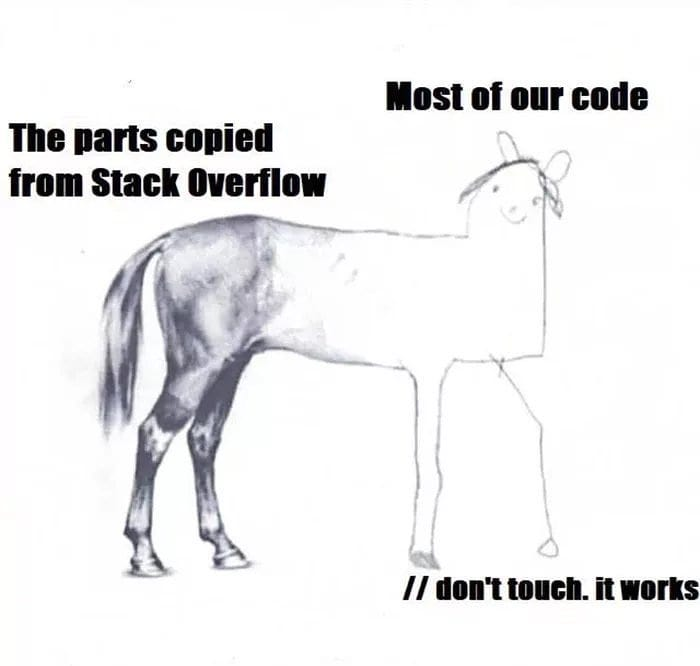

## How does Numpy work?
The base component in Numpy is an array. In short it works like an algebraic matrix: it can have one or more dimensions. 

A numpy array is a grid of values, **all of the same type**. It smartly stores data in one place in the computer memory, unlike other Python array-like objects. Those are scattered in memory and the code just has links to those locations. It's easy to use, but performance suffers a lot.


### SciPy : TODO
SciPy is an open-source Python library used for scientific and technical computing. It has several sub-packages, such as on covering constants, spatial algorithms (e.g. distance, nearest neighbor fuctions), linear algebra methods and many more. It is built on top of NumPy, making it not only a useful, but also a powerful tool. More about it [here](https://www.tutorialspoint.com/scipy/index.htm).

This library will not be used in the following exercise, but it will prove very useful if you need to do more complex linear algebra routines, such as integration.

### Let's create a NumPy array

In [ ]:
import numpy as np

# Create a rank 1 array (1D matrix)
a = np.array([1, 2, 3])   

print(a)        
print(type(a))            
print(a.shape)            
print(a[0], a[1], a[2]) 
a[0] = 5
print(a) 

Arrays can be made in many other ways and remembering this functionality (or printing out a cheat sheet) will save you precious coding time. Also, you are **not** limited to 2 dimensions: all examples below can be extended by 1 dimension by adding an additional value after the comma.

In [ ]:
# Creates an array of all zeros
a = np.zeros((2,2))  
print(a)              
                      
# Creates an array of all ones
b = np.ones((2,3))    
print('\n',b)              

# Creates an array of all of a specific number (5 in this case)
c = np.full((2,2), 5)  
print('\n',c)               
                       
# Creates an identity matrix of a specified size (3 in this case)
d = np.eye(3)         
print('\n',d)              
                      
# Creates a 2x3 array filled with random values in [0,5)
e = np.random.random((2,5))  
print('\n',e)    

### Exercise 1
Create an identity matrix of size 3, then change all the ones to a different value each.

In [ ]:
array = np.eye(3)

array[0,0]=2
array[1,1]=4
array[2,2]=18

array

### Performance example
To compare the performance of pure Python and Numpy, follow the pseudocode instructions in the next cells.

In [ ]:
# Leave it empty and use as example

# create a list, containing 1000**2 lists of [2,2,2]

my_list = []
for x in range(1000**2):
    my_list.append([2,2,2])

In [ ]:
def python_test(my_list):
    # multiply each number by 3
    for i in range(len(my_list)):
        for x in range(len(my_list[i])):
            my_list[i][x]=my_list[i][x]*3

%time python_test(my_list)        

In [ ]:
# create an array of 3x1000**2 containing only 2s
array = np.full((3,1000**2), 2) 

In [ ]:
def numpy_test(array):
    # multiply each number in the array by 3
    array = array * 3
    
%time numpy_test(array) 

# Dynamic relaxation
This exercise consists of 3 main steps:
1. Reading in the data and defining the initial state of the mesh
2. Relaxing the mesh
3. Plotting the results


In [48]:
# For step 2
from numpy import array, zeros, float64, append, sqrt, sign

# For step 3
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# necessary only for the Jupyter notebook
%matplotlib notebook 

## 1. Reading in the data and defining the initial state of the mesh
During this step we need to read in the data, parse it to something we can manipulate, pre-process the geometeries and pass the results/ initial state of the mesh to the next process. The expected outputs of this step are:
* points : List of points
* edges : List of edges
* vertices : List of vertices
* xyzIS : Initial state of the system
* bbmax, bbmin : Bounding box of the mesh


The only **input** for the first step of the exercise in the location of the *mesh file (.obj)* you received together with this notebook.

To begin with, let's locate the file and open it:

In [49]:
filename = 'BasicRhinoOutput.obj'
#filename=filename.replace('\','//')
# opening the file
def open_obj_file(filename):
    with open(filename, 'r') as myfile:
        return myfile.read().split('\n')

### What is inside of data? (for a more elaborate description of the format, check out this [link](http://paulbourke.net/dataformats/obj/))

In [50]:
data = open_obj_file(filename)
data

['# Rhino',
 '',
 'v 0 0 0',
 'v 0 1 0',
 'v 0 2 0',
 'v 0 3 0',
 'v 0 4 0',
 'v 0 5 0',
 'v 0 6 0',
 'v 0 7 0',
 'v 0 8 0',
 'v 0 9 0',
 'v 0 10 0',
 'v 1 0 0',
 'v 1 1 0',
 'v 1 2 0',
 'v 1 3 0',
 'v 1 4 0',
 'v 1 5 0',
 'v 1 6 0',
 'v 1 7 0',
 'v 1 8 0',
 'v 1 9 0',
 'v 1 10 0',
 'v 2 0 0',
 'v 2 1 0',
 'v 2 2 0',
 'v 2 3 0',
 'v 2 4 0',
 'v 2 5 0',
 'v 2 6 0',
 'v 2 7 0',
 'v 2 8 0',
 'v 2 9 0',
 'v 2 10 0',
 'v 3 0 0',
 'v 3 1 0',
 'v 3 2 0',
 'v 3 3 0',
 'v 3 4 0',
 'v 3 5 0',
 'v 3 6 0',
 'v 3 7 0',
 'v 3 8 0',
 'v 3 9 0',
 'v 3 10 0',
 'v 4 0 0',
 'v 4 1 0',
 'v 4 2 0',
 'v 4 3 0',
 'v 4 4 0',
 'v 4 5 0',
 'v 4 6 0',
 'v 4 7 0',
 'v 4 8 0',
 'v 4 9 0',
 'v 4 10 0',
 'v 5 0 0',
 'v 5 1 0',
 'v 5 2 0',
 'v 5 3 0',
 'v 5 4 0',
 'v 5 5 0',
 'v 5 6 0',
 'v 5 7 0',
 'v 5 8 0',
 'v 5 9 0',
 'v 5 10 0',
 'v 6 0 0',
 'v 6 1 0',
 'v 6 2 0',
 'v 6 3 0',
 'v 6 4 0',
 'v 6 5 0',
 'v 6 6 0',
 'v 6 7 0',
 'v 6 8 0',
 'v 6 9 0',
 'v 6 10 0',
 'v 7 0 0',
 'v 7 1 0',
 'v 7 2 0',
 'v 7 3 0',
 'v 

### How do we make this readable?

In [51]:
def process_obj_file(data):
    # initiating the output
    xyz = []  # xyz coordinates
    points = []  # references to vertices
    lines = []  # pairs of references to vertices
    
    # parsing the obj file, filling the data lists
    for line in data:
        # split the string line by ' '
        parts = line.split(' ')

        # TODO: this seems unnecessary
        # checking if it contains data 
        if not parts:
            continue

        # assigning the 1st element to head and the rest to tail 
        head = parts[0]
        tail = parts[1:]

        # appending vertex cordinations in (xyz) and assigning an index to them in (points)
        if head == 'v':
            ftail = [float(x) for x in tail]
            xyz.append(ftail)
            points.append(len(xyz)-1)
        # iterating through the edges of the faces and appending them in (lines)
        elif head == 'f':
            ftail = [float(x) for x in tail]
            for i in range(len(ftail)):
                sp = ftail[i%len(ftail)]
                ep = ftail[(i+1)%len(ftail)]
                lines.append((int(sp)-1, int(ep)-1))
    return xyz, points, lines

In [52]:
xyz, points, lines = process_obj_file(data)
xyz

[[0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0],
 [0.0, 2.0, 0.0],
 [0.0, 3.0, 0.0],
 [0.0, 4.0, 0.0],
 [0.0, 5.0, 0.0],
 [0.0, 6.0, 0.0],
 [0.0, 7.0, 0.0],
 [0.0, 8.0, 0.0],
 [0.0, 9.0, 0.0],
 [0.0, 10.0, 0.0],
 [1.0, 0.0, 0.0],
 [1.0, 1.0, 0.0],
 [1.0, 2.0, 0.0],
 [1.0, 3.0, 0.0],
 [1.0, 4.0, 0.0],
 [1.0, 5.0, 0.0],
 [1.0, 6.0, 0.0],
 [1.0, 7.0, 0.0],
 [1.0, 8.0, 0.0],
 [1.0, 9.0, 0.0],
 [1.0, 10.0, 0.0],
 [2.0, 0.0, 0.0],
 [2.0, 1.0, 0.0],
 [2.0, 2.0, 0.0],
 [2.0, 3.0, 0.0],
 [2.0, 4.0, 0.0],
 [2.0, 5.0, 0.0],
 [2.0, 6.0, 0.0],
 [2.0, 7.0, 0.0],
 [2.0, 8.0, 0.0],
 [2.0, 9.0, 0.0],
 [2.0, 10.0, 0.0],
 [3.0, 0.0, 0.0],
 [3.0, 1.0, 0.0],
 [3.0, 2.0, 0.0],
 [3.0, 3.0, 0.0],
 [3.0, 4.0, 0.0],
 [3.0, 5.0, 0.0],
 [3.0, 6.0, 0.0],
 [3.0, 7.0, 0.0],
 [3.0, 8.0, 0.0],
 [3.0, 9.0, 0.0],
 [3.0, 10.0, 0.0],
 [4.0, 0.0, 0.0],
 [4.0, 1.0, 0.0],
 [4.0, 2.0, 0.0],
 [4.0, 3.0, 0.0],
 [4.0, 4.0, 0.0],
 [4.0, 5.0, 0.0],
 [4.0, 6.0, 0.0],
 [4.0, 7.0, 0.0],
 [4.0, 8.0, 0.0],
 [4.0, 9.0, 0.0],
 [4.0, 10.0, 0.0],
 [5.0

### How do we preprocess the data?

In [53]:
def mesh_welding(xyz):
    
    # This is how we store the welded points
    vertices = []
    
    # initiating the bounding box max and min point
    bbmax = [0,0,0]
    bbmin = [0,0,0]

    # points to vertices (welding similar vertices)
    x2v = {}
    tol = 0.001 ** 2

    for i, x in enumerate(xyz):
        found = False
        for j, v in enumerate(vertices):
            if (x[0] - v[0]) ** 2 < tol \
                    and (x[1] - v[1]) ** 2 < tol \
                    and (x[2] - v[2]) ** 2 < tol:
                found = True
                x2v[i] = j
                break
        if not found:
            x2v[i] = len(vertices)
            vertices.append(x)

        #finding the bounding box
        for i in range(3):
            if x[i] > bbmax[i]: 
                bbmax[i] = x[i]
            if x[i] < bbmin[i]: 
                bbmin[i] = x[i]
    return bbmin, bbmax, vertices, x2v

In [54]:
bbmin, bbmax, vertices, x2v = mesh_welding(xyz)
vertices

[[0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0],
 [0.0, 2.0, 0.0],
 [0.0, 3.0, 0.0],
 [0.0, 4.0, 0.0],
 [0.0, 5.0, 0.0],
 [0.0, 6.0, 0.0],
 [0.0, 7.0, 0.0],
 [0.0, 8.0, 0.0],
 [0.0, 9.0, 0.0],
 [0.0, 10.0, 0.0],
 [1.0, 0.0, 0.0],
 [1.0, 1.0, 0.0],
 [1.0, 2.0, 0.0],
 [1.0, 3.0, 0.0],
 [1.0, 4.0, 0.0],
 [1.0, 5.0, 0.0],
 [1.0, 6.0, 0.0],
 [1.0, 7.0, 0.0],
 [1.0, 8.0, 0.0],
 [1.0, 9.0, 0.0],
 [1.0, 10.0, 0.0],
 [2.0, 0.0, 0.0],
 [2.0, 1.0, 0.0],
 [2.0, 2.0, 0.0],
 [2.0, 3.0, 0.0],
 [2.0, 4.0, 0.0],
 [2.0, 5.0, 0.0],
 [2.0, 6.0, 0.0],
 [2.0, 7.0, 0.0],
 [2.0, 8.0, 0.0],
 [2.0, 9.0, 0.0],
 [2.0, 10.0, 0.0],
 [3.0, 0.0, 0.0],
 [3.0, 1.0, 0.0],
 [3.0, 2.0, 0.0],
 [3.0, 3.0, 0.0],
 [3.0, 4.0, 0.0],
 [3.0, 5.0, 0.0],
 [3.0, 6.0, 0.0],
 [3.0, 7.0, 0.0],
 [3.0, 8.0, 0.0],
 [3.0, 9.0, 0.0],
 [3.0, 10.0, 0.0],
 [4.0, 0.0, 0.0],
 [4.0, 1.0, 0.0],
 [4.0, 2.0, 0.0],
 [4.0, 3.0, 0.0],
 [4.0, 4.0, 0.0],
 [4.0, 5.0, 0.0],
 [4.0, 6.0, 0.0],
 [4.0, 7.0, 0.0],
 [4.0, 8.0, 0.0],
 [4.0, 9.0, 0.0],
 [4.0, 10.0, 0.0],
 [5.0

### Anything we forgot?

In [55]:
# redefining the indexes
points[:] = [x2v[index] for index in points]

# redefining the edges by the refined indexes
edges = [(x2v[u[0]], x2v[u[1]]) for u in lines]

# reserving the Initial State of the system
import copy
xyzIS = copy.deepcopy(vertices)

### How does the initial state look like?

In [56]:
xyzIS == vertices

True

# Dynamic relaxation
### Input data:
* vertices: a list of unique xyz coordinates
* edges: a list of pairs of vertex indices
* points: index list of fixed vertices
* bbmax, bbmin : Bounding box coordinate list

### Output data:
* xyzFS : Final state of the system

In [57]:
# fixed points here are set to be the boundary of the rectangle
fixed = []
for i, pnt in enumerate(iter(xyz)):
    # check if the points are no closer to 
    if abs(pnt[0] - bbmin[0]) < 0.01  \
        or abs(pnt[0] - bbmax[0]) < 0.01 \
        or abs(pnt[1] - bbmin[1]) < 0.01 \
        or abs(pnt[1] - bbmax[1]) < 0.01:
        fixed.append(i)

In [58]:
no_vert = len(vertices) 
no_ed = len(edges)

freePoints = list(set(range(no_vert)) - set(fixed))

xyz = array(vertices)

# p : Applied Load Component which in our case is zero
p = zeros((no_vert, 3), dtype=float64)

# W : Gravity Force
W = array([array([0,0,9.8]) for i in range(no_vert)])

# v : Velosity
v = zeros((no_vert, 3), dtype=float64)


# restlength : Rest Length of the springs
diff = array([(xyz[edges[i][1]] - xyz[edges[i][0]]) for i in range(no_ed)])

restlength = array([sqrt(diff[i,0]*diff[i,0] + diff[i,1]*diff[i,1] + diff[i,2]*diff[i,2]) for i in range(no_ed)])

# adamp : Acceleration damp controls the stability of the system
adamp = 10
IterationMax = 100

# K : Elasticity Constant in Hooke's law
K = 20

# dt : Time intervals
dt = 0.1
mass = 1

In [59]:
for k in range(IterationMax):
    
    # S : Stiffness Force
    S = zeros((no_vert, 3), dtype=float64)
    # R : Final Forces
    R = zeros((no_vert, 3), dtype=float64)
        
    # xyz0 : Initial Position
    xyz0 = xyz.copy()
    # vp : Initial Velocity
    vp = v.copy()
    
    # calculating the length of the edges
    di = array([(xyz[edges[i][1]] - xyz[edges[i][0]]) for i in range(no_ed)])
    dist = array([sqrt(di[i,0]*di[i,0] + di[i,1]*di[i,1] + di[i,2]*di[i,2]) for i in range(no_ed)])

    # Hooke's law : Force = length difference * Elasticity Constant (K)
    EdgeForce = (dist - restlength) * K
    # Edge Force : Decomposing the existing force in each edge into the 3 dimensions 
    EdgeForceS = zeros((no_ed, 3), dtype=float64)

    # iterating throughout the edges
    for i in range(no_ed):
        for j in range(3):
            # Separating the forces into X, Y, Z dimensions
            EdgeForceS[i,j] = (di[i,j] / dist[i]) * EdgeForce[i]

        # Adding the force of each edge to the coresponding nodes
        S[edges[i][0]] -= EdgeForceS[i]
        S[edges[i][1]] += EdgeForceS[i]
    
    R[freePoints] = p[freePoints] + W[freePoints] - S[freePoints]

    A = 1/(1 + adamp * dt * 0.5)
    B = (1 - adamp * dt * 0.5 ) / (1 + adamp * dt * 0.5)
    
    # updating the velocity
    v[freePoints] = A * dt * R[freePoints] / mass + B * vp[freePoints]
    # updating the position
    xyz[freePoints] = xyz0[freePoints] + dt * v[freePoints]


xyzFS = xyz

# 3. Plotter

The last step of the process uses Matplotlib library used in the previous workshop. In this step we will create a visualization for the initial state and/or final state of the system. Our inputs are:

* xyzIS : initial state of the system
* xyzFS : final state of the system
* *Optional* bbmax, bbmin : Bounding box coordinate list

<IPython.core.display.Javascript object>


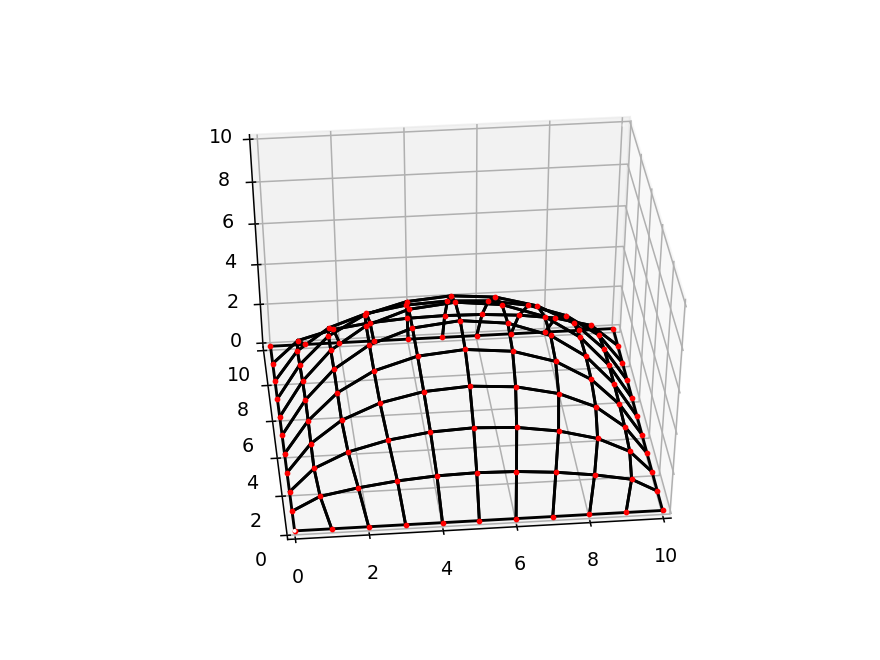

In [40]:
coordinates = xyzFS

# initiating the plotter
fig = plt.figure()
ax = fig.gca(projection='3d')

# plotting edges
for u, v in edges:
    ax.plot([coordinates[u][0], coordinates[v][0]],
            [coordinates[u][1], coordinates[v][1]],
            [coordinates[u][2], coordinates[v][2]], color='k')

# plotting points
for i in points:
    ax.scatter(coordinates[i][0], coordinates[i][1], coordinates[i][2],
               color='r', s=4)

ax.scatter([bbmin[0], bbmax[0]], [bbmin[1], bbmax[1]], [bbmin[2], bbmax[2]+10], color='w', s=1)
ax.set_xlim([bbmin[0], bbmax[0]])
ax.set_ylim([bbmin[1], bbmax[1]])
ax.set_zlim([bbmin[2], bbmax[2]+10])
# ax.set_aspect('equal')

plt.show()


# A library that works a bit faster ...
[Plotly](https://plot.ly/python/) is another open source library for Python, that works significantly faster than Matplotlib on Jupyter notebooks. Also, it's a bit easier to use: see for yourself below.

In [44]:
import plotly.graph_objects as go
import numpy as np
# Here we extract the me
sh coordinates from the final state NumPy array
xFS, yFS, zFS = xyzFS.T

# Initial state data is still in list format, so we first convert it to a NumPy array
xIS, yIS, zIS = np.array(xyzIS).T

fig = go.Figure(data=[  go.Mesh3d(x=xIS, y=yIS, z=zIS, color='blue', opacity=0.5),
                        go.Mesh3d(x=xFS, y=yFS, z=zFS, colorscale='Viridis', opacity=0.5),
                        go.Scatter3d(mode = 'markers', x=xFS, y=yFS, z=zFS,
                            marker=dict(size=3, color='red'), showlegend=False),
                        go.Scatter3d(mode = 'markers', x=xIS, y=yIS, z=zIS,
                            marker=dict(size=3, color='blue'), showlegend=False)
                     ]
               )
fig.show()

In [45]:
points = go.Scatter3d(
    mode = 'markers',
    showlegend = False,
    x=xFS, y=yFS, z=zFS,
    marker=dict(
        size=4,
        color='red',
       ))

coordinates = xyzFS
lines = []
for u, v in edges:
    lines.append(go.Scatter3d(
#         mode='lines',
        x = [coordinates[u][0], coordinates[v][0]],
        y = [coordinates[u][1], coordinates[v][1]],
        z = [coordinates[u][2], coordinates[v][2]],
        line=dict(color='black'),
        marker=dict(color='red', size=4),
        showlegend = False
                ))
        
fig = go.Figure(data=lines)

fig.show()